# Model for predicting sentiment from movie review

In our project we have performed sentiment analysis using two main models: TextBlob with Bayes, and SVM. We trained our SVM model using Stanford's Large Movie Review dataset [1]. The objective was to predict the sentiment (Positive or Negative) of each review directly by the text without considering any additional feature of the movie, such as the title, rating, genre, etc. In this way we were able to derive a sentiment classification on a per-review basis, rather than a per-movie rating.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import glob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

SVM is a supervised machine learning algorithm, and hence it requires a labeled dataset for training. Due to its popularity and broad use in several research papers, the Stanford Large Movie Dataset is frequently recognised and employed for sentiment analysis tasks. This dataset has been used by many academics to investigate and apply various sentiment analysis algorithms, making it a trustworthy and worthwhile resource in this area of study [2] [3].
The dataset is composed of 50k movie reviews labelled as Positive/Negative. It is already divide into training and test, where each dataset is composed as follows:
<ul>
    <li> 12,500 samples of Posititve movie reviews </li>
    <li> 12,500 samples of Negative movie reviews </li>
</ul>
This makes the dataset perfectly balanced, with 25,000 positive reviews and 25,000 negative reviews, equally divided into training and testing.

### Loading train data

Positive class

In [2]:
#Name of files
path = 'data/train/pos'
flist = glob.glob(path + '/*.txt')

In [3]:
dataP = pd.DataFrame({'text': []})
for file in flist:
    with open(file, encoding='utf-8') as f:
        text = f.read()
    df = pd.DataFrame(text, columns=["text"], index=[0])
    dataP = dataP.append(df, ignore_index=True)

In [4]:
dataP.shape

(12500, 1)

In [5]:
dataP.head()

text
0  Bromwell High is a cartoon comedy. It ran at t...
1  Homelessness (or Houselessness as George Carli...
2  Brilliant over-acting by Lesley Ann Warren. Be...
3  This is easily the most underrated film inn th...
4  This is not the typical Mel Brooks film. It wa...

Creating the labels for the postive class

In [6]:
#Positive class labels
labelP = pd.DataFrame({'label':["Positive"]*12500})

In [7]:
labelP.shape

(12500, 1)

In [8]:
labelP.head()

label
0  Positive
1  Positive
2  Positive
3  Positive
4  Positive

Negative class

In [9]:
#Name of files
path = 'data/train/neg'
flist = glob.glob(path + '/*.txt')

In [10]:
dataN = pd.DataFrame({'text': []})
for file in flist:
    with open(file, encoding='utf-8') as f:
        text = f.read()
    df = pd.DataFrame(text, columns=["text"], index=[0])
    dataN = dataN.append(df, ignore_index=True)

In [11]:
dataN.shape

(12500, 1)

In [12]:
dataN.head()

text
0  Story of a man who has unnatural feelings for ...
1  Airport '77 starts as a brand new luxury 747 p...
2  This film lacked something I couldn't put my f...
3  Sorry everyone,,, I know this is supposed to b...
4  When I was little my parents took me along to ...

Creating the labels for the negative class

In [13]:
labelN = pd.DataFrame({'label':["Negative"]*12500})

In [14]:
labelN.shape

(12500, 1)

In [15]:
labelN.head()

label
0  Negative
1  Negative
2  Negative
3  Negative
4  Negative

Combining data

In [16]:
X_train = dataP.append(dataN, ignore_index=True).values.ravel()
y_train = labelP.append(labelN, ignore_index=True).values.ravel()

In [17]:
(X_train.shape, y_train.shape)

((25000,), (25000,))

### Analysis on train data

The training dataset was analysed to determine the words that appeared most frequently in both positive and negative reviews. Through this analysis, we found that while "br" was the most often used tag, it had no use for us. As a result, we made the decision to add "br" to the list of stopwords because it does not add to the reviews' overall meaning.

Positive class

In [18]:
import nltk
nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words('english'))

include = {"br"}

stopwords |= include

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hitas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(-0.5, 399.5, 199.5, -0.5)

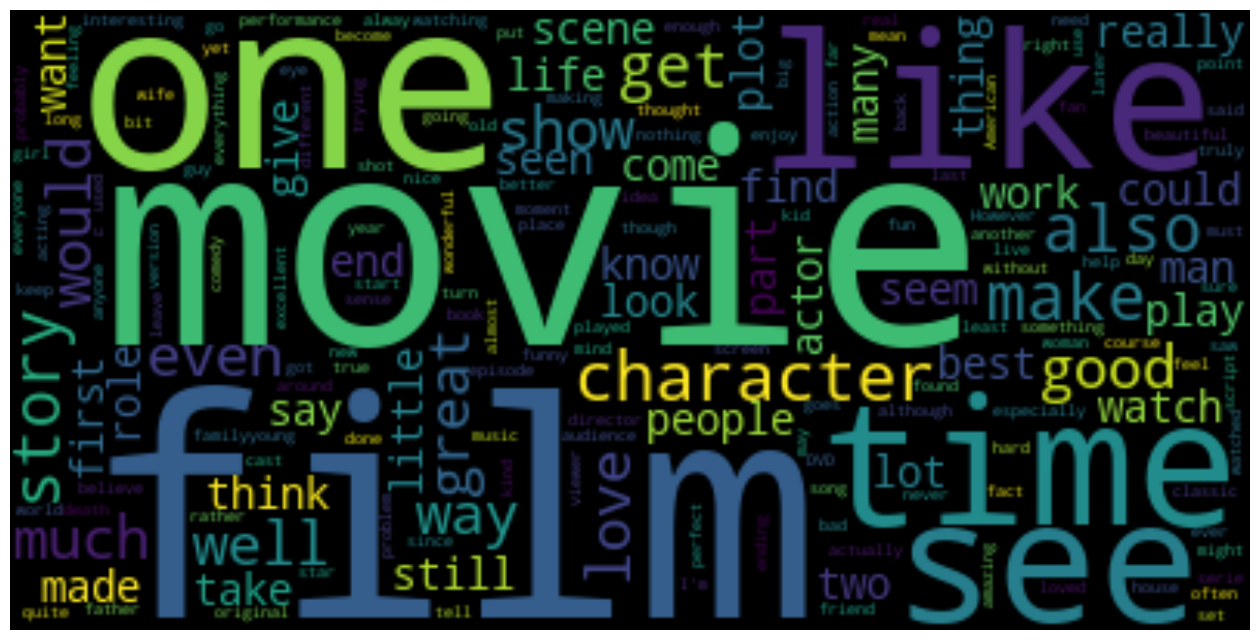

In [19]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

text = dataP['text'].values


wc = WordCloud(max_words=200, stopwords = stopwords)
wc.generate(''.join(text))

plt.figure(figsize=(16,9))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

From a first analysis we identified that the words "movie" and "film" appeared most frequently in the reviews. We decided to include these words to our list of stopwords because our main concentration is on movie reviews. This decision was made because these popular terms lack considerable importance for the sentiment classification problem.

In [20]:
#Including "film" and "movie" in stopwords
include = {"film", "movie","like","one","make","even"}

stopwords |= include

(-0.5, 399.5, 199.5, -0.5)

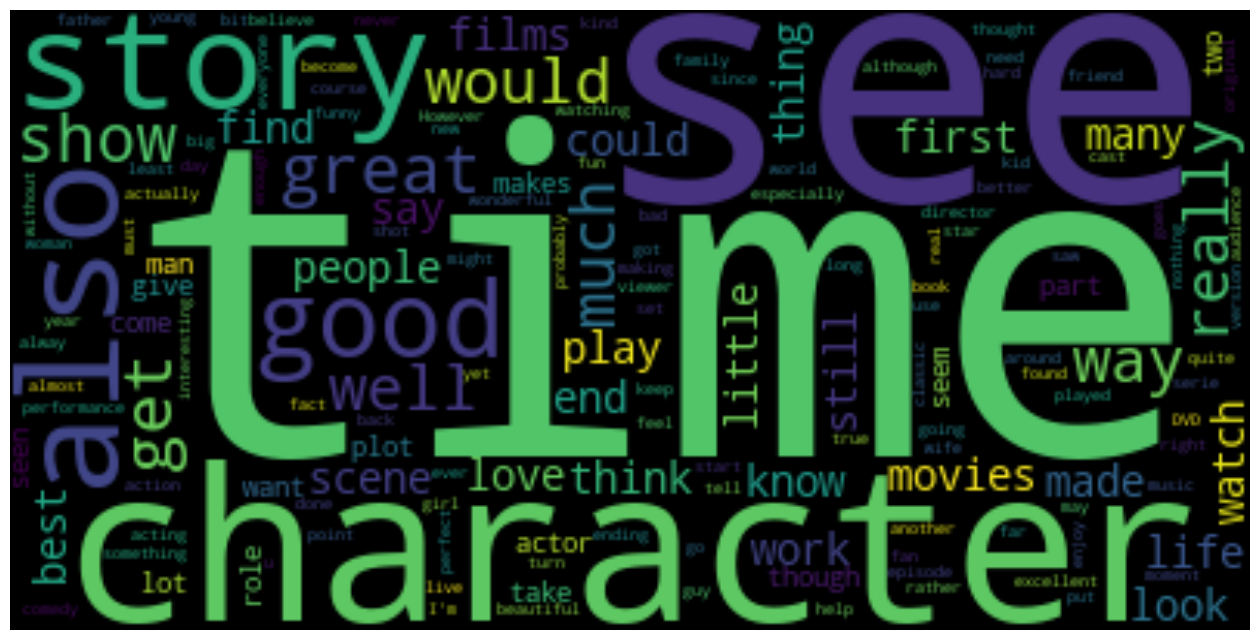

In [21]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

text = dataP['text'].values


wc = WordCloud(max_words=200, stopwords = stopwords)
wc.generate(''.join(text))

plt.figure(figsize=(16,9))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

Negative class

(-0.5, 399.5, 199.5, -0.5)

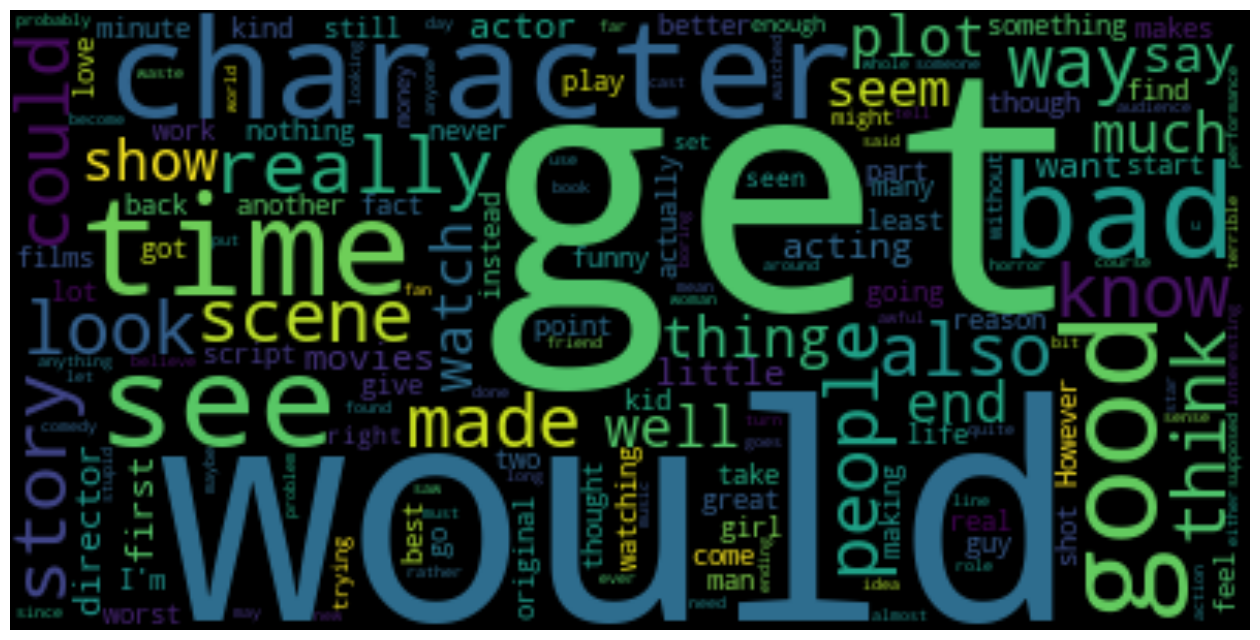

In [22]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

textN = dataN['text'].values


wc = WordCloud(max_words=200, stopwords = stopwords)
wc.generate(''.join(textN))

plt.figure(figsize=(16,9))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

In [23]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hitas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

A sentiment is determined by the following elements:
<ul>
    <li> words and phrases (adjectives, adverbs, etc.) </li>
    <li> context (movie rewies, product comments, etc.) </li>
    <li> tone and intensity </li>
    <li> negation and contrast ("it's a one time watch" vs "it's NOT a one time watch") </li>
</ul>
We have decided to focus on the first of this components. Our attention is specifically on the most often used adjectives in both postive and negative reviews.

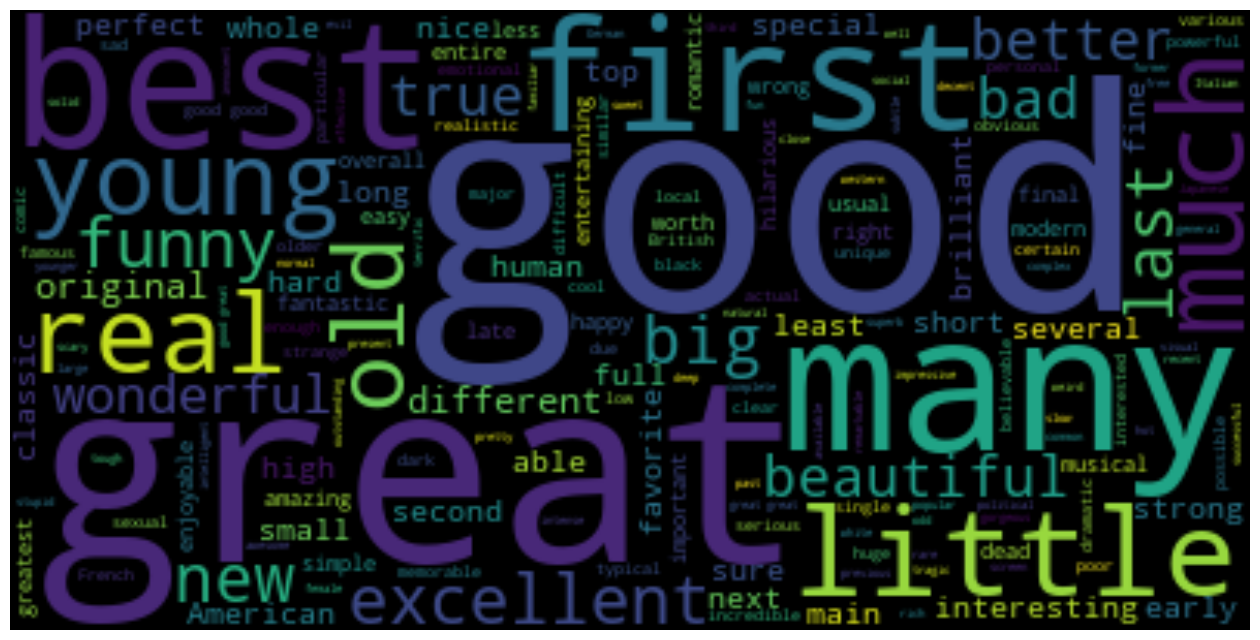

In [24]:
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = dataP['text'].values

# Tokenize the text
tokens = [word_tokenize(sentence) for sentence in text]

# Perform part-of-speech tagging
pos_tags = [pos_tag(sentence) for sentence in tokens]

# Filter out adjectives
adjectives = [word for sentence in pos_tags for (word, tag) in sentence if tag.startswith('JJ')]

# Generate the word cloud
wc = WordCloud(max_words=200, stopwords=stopwords)
wc.generate(' '.join(adjectives))

plt.figure(figsize=(16, 9))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Here are the most common adjectvies used in positive reviews (great, good, best, etc)

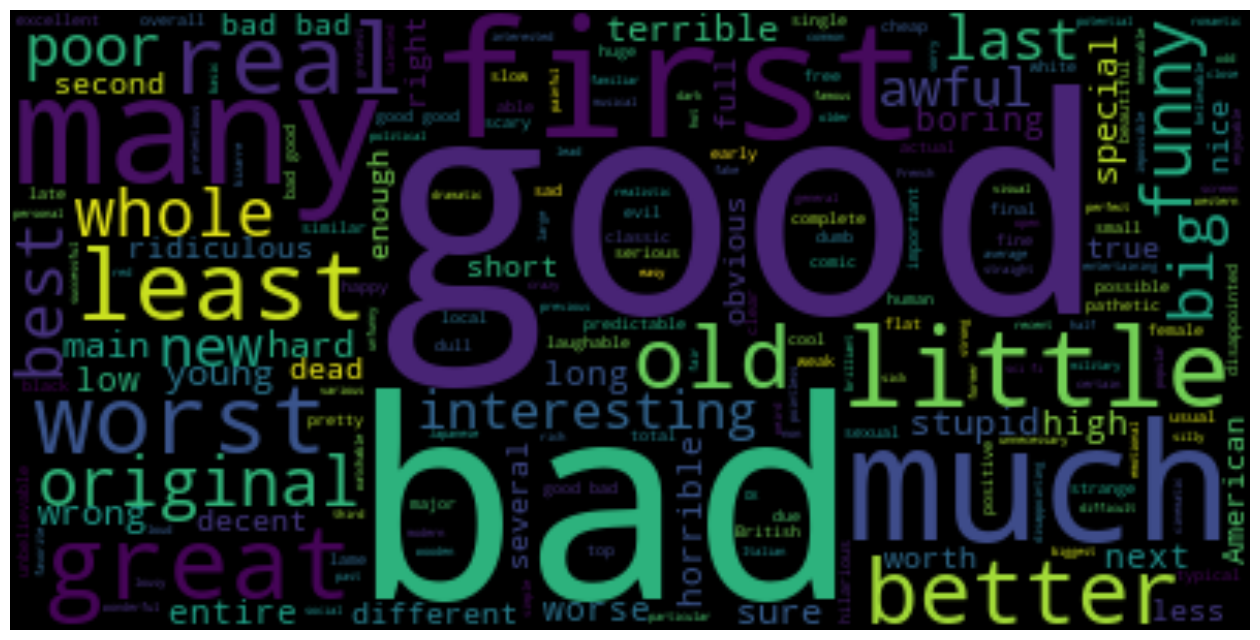

In [25]:
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = dataN['text'].values

# Tokenize the text
tokens = [word_tokenize(sentence) for sentence in text]

# Perform part-of-speech tagging
pos_tags = [pos_tag(sentence) for sentence in tokens]

# Filter out adjectives
adjectives = [word for sentence in pos_tags for (word, tag) in sentence if tag.startswith('JJ')]

# Generate the word cloud
wc = WordCloud(max_words=200, stopwords=stopwords)
wc.generate(' '.join(adjectives))

plt.figure(figsize=(16, 9))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Here are the adjectives used for negative reviews. 
Note: there is also good in this list because it was used in a negative context "not good"

### Loading test data

In [26]:
#Name of files
path = 'data/test/pos'
flist = glob.glob(path + '/*.txt')

In [27]:
dataP = pd.DataFrame({'text': []})
for file in flist:
    with open(file, encoding='utf-8') as f:
        text = f.read()
    df = pd.DataFrame(text, columns=["text"], index=[0])
    dataP = dataP.append(df, ignore_index=True)

In [28]:
dataP.shape

(12500, 1)

In [29]:
labelP.head()

label
0  Positive
1  Positive
2  Positive
3  Positive
4  Positive

In [30]:
#Name of files
path = 'data/test/neg'
flist = glob.glob(path + '/*.txt')

In [31]:
dataN = pd.DataFrame({'text': []})
for file in flist:
    with open(file, encoding='utf-8') as f:
        text = f.read()
    df = pd.DataFrame(text, columns=["text"], index=[0])
    dataN = dataN.append(df, ignore_index=True)

In [32]:
dataN.shape

(12500, 1)

In [33]:
dataN.head()

text
0  Once again Mr. Costner has dragged out a movie...
1  This is an example of why the majority of acti...
2  First of all I hate those moronic rappers, who...
3  Not even the Beatles could write songs everyon...
4  Brass pictures (movies is not a fitting word f...

In [34]:
labelN = pd.DataFrame({'label':["Negative"]*12500})

In [35]:
labelN.shape

(12500, 1)

In [36]:
X_test = dataP.append(dataN, ignore_index=True).values.ravel()
y_test = labelP.append(labelN, ignore_index=True).values.ravel()

In [37]:
(X_test.shape,y_test.shape)

((25000,), (25000,))

### Training model

In [38]:
import nltk
nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hitas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
len(stopwords)

179

Run only once: takes approximately 30 minutes

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=list(stopwords))),
    ('clf', svm.SVC()),
])


# Train the classifier
text_clf.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['my', 'why', 'him', 'while',
                                             'yourself', 'that', "shouldn't",
                                             'very', 'few', 'don', 'd', 'ma',
                                             'nor', "wasn't", 'i', 'were',
                                             'couldn', 'through', 'do', 'by',
                                             'as', "she's", 'than', 'at',
                                             'with', 'is', 'all', 'wasn', 'our',
                                             'those', ...])),
                ('clf', SVC())])

In [41]:
y_pred = text_clf.predict(X_train)

print(classification_report(y_train,y_pred,target_names=['Positive','Negative']))

              precision    recall  f1-score   support

    Positive       0.99      0.99      0.99     12500
    Negative       0.99      0.99      0.99     12500

    accuracy                           0.99     25000
   macro avg       0.99      0.99      0.99     25000
weighted avg       0.99      0.99      0.99     25000



In [42]:
y_pred.shape

(25000,)

## Testing the model

In [43]:
y_pred = text_clf.predict(X_test)

print(classification_report(y_test,y_pred,target_names=['Positive','Negative']))

              precision    recall  f1-score   support

    Positive       0.88      0.89      0.88     12500
    Negative       0.89      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



Remarkable classification results were obtained for the sentiment analysis problem, with precision and recall scores for both positive and negative classes remaining continuously high. The model correctly classified 88% of the test samples, as seen by its total accuracy of 88%. The F1-score of 0.88 indicates that both classes performed equally well. These outcomes demonstrate the resilience and efficacy of the model in correctly categorising sentiment throughout the given dataset of 25,000 reviews.

## Reddit data

In this section we try to predict the sentiment for the reviews collected from the subreddit r/HorrorReviewed using the above trained SVM.

In [44]:
reddit = pd.read_csv('data/horror1000.csv')

data = reddit[["selftext"]].fillna('')


data.head()

selftext
0  **“Midsommar” basks in its own radiant glory. ...
1  **PONTYPOOL (2008)** \- Last year I watched (o...
2  "It's just a color."\n-Ezra\n\n\n\nThe Gardner...
3  **Well we did it! And a whole lot sooner than ...
4  **THE AUTOPSY OF JANE DOE (2016)**\n\nTommy (B...

In [45]:
X_real = data.values.ravel()

In [46]:
data['Prediction'] = text_clf.predict(X_real)

In [47]:
data.head()

selftext Prediction
0  **“Midsommar” basks in its own radiant glory. ...   Positive
1  **PONTYPOOL (2008)** \- Last year I watched (o...   Positive
2  "It's just a color."\n-Ezra\n\n\n\nThe Gardner...   Positive
3  **Well we did it! And a whole lot sooner than ...   Positive
4  **THE AUTOPSY OF JANE DOE (2016)**\n\nTommy (B...   Positive

In [48]:
data[data['Prediction']=='Positive']

selftext Prediction
0    **“Midsommar” basks in its own radiant glory. ...   Positive
1    **PONTYPOOL (2008)** \- Last year I watched (o...   Positive
2    "It's just a color."\n-Ezra\n\n\n\nThe Gardner...   Positive
3    **Well we did it! And a whole lot sooner than ...   Positive
4    **THE AUTOPSY OF JANE DOE (2016)**\n\nTommy (B...   Positive
..                                                 ...        ...
991  **The Nightshifter - A Movie Meows Mini-Review...   Positive
993  The Babysitter: Killer Queen\n\n*The Babysitte...   Positive
994  **SISTERS OF THE PLAGUE (2015)**\n\nJo (Joseph...   Positive
997  **THE WIZARD OF GORE (2007):** I’m not a big f...   Positive
999  **THE DARK** always stood out in my mind as on...   Positive

[753 rows x 2 columns]

In [65]:
print(data.loc[0]['selftext'])

**“Midsommar” basks in its own radiant glory. By incorporating its luminous cinematography, raw acting of Florence Pugh and visionary direction of Aster, this bizarre drama leaves a long-lasting impression of overwhelming grandeur.** ﻿  


Dani (Florence Pugh) isn’t on particularly good terms with her boyfriend Christian (Jack Reynor). She is, however, very attached to him. When a tragic event leads to her family’s death, Dani is left with Christian by her side. In order to help her cope with loneliness and the agonizing pain, he invites Dani to a trip to Sweden along with a bunch of friends. However, the trip to Midsommar festival isn’t exactly what they expected.

Ari Aster, the director of “Midsommar”, faced a challenging task. In his second directorial work, he had to deliver a film at least as good as his stunning debut, “Hereditary”. Driven by Toni Collette’s exaggerated yet straight-out bewildering performance, “Hereditary” gave grounds to a belief that Aster’s a name to keep an

This is an example of a review which has been classified as positive by the model. By reading the review it was evident that this user liked the movie "Midsommar". Since the title of the movie was included in the review, it was possible to check its rating on IMDB: 7.1/10

In [66]:
data[data['Prediction']=='Negative'][:40]

selftext Prediction
7    [Bubba Ho-Tep](https://vocal.media/horror/reed...   Negative
27   You know, I have to say, I was expecting this ...   Negative
34   "I can smell my friend being cooked."\n-Lars\n...   Negative
40   Don't mind me, Mr. Slowpoke, just catching up ...   Negative
44                                                       Negative
51   # A memory of Sid Haig\n\nI haven't watched th...   Negative
60   During interviews, Nicolas Cage has described ...   Negative
64   **MANDY (2018)**: In 1983, Red Miller (Nicolas...   Negative
65   "Thank you, have a nice day."\n\nA group of ho...   Negative
69   There’s a certain irony of being a Hellraiser ...   Negative
75   # [Suspiria](https://vocal.media/horror/reed-a...   Negative
84   **THE KILLING OF A SACRED DEER (2017)**\n\nSte...   Negative
93   'The Green Inferno' is what appears to be a ho...   Negative
94   ### | [THE NUN (2018)](https://www.imdb.com/ti...   Negative
96    "Scott, was that a zombie in a goddamn cape?"...   Negative
101  # And now for an old classic in fucking BAD mo...   Negative
109  Basic plot: A crew explores a spaceship which ...   Negative
120  **HELL HOUSE LLC 2: THE ABADDON HOTEL (2018)**...   Negative
123  And so we begin 2020 with the first Horror rel...   Negative
124  # How we brought Kaiju back to horror\n\nAs a ...   Negative
133  [Cube (1997)](https://vocal.media/horror/reed-...   Negative
153  ### | [HUNTER HUNTER (2020)](https://www.imdb....   Negative
165  ----------------------------------------------...   Negative
168   "I'll light the match."\n-Corey Cunningham\n\...   Negative
171  This story is pretty much Carlton Mellick III'...   Negative
172  Often regarded as Dario Argento's masterwork, ...   Negative
175  **THE GHOUL (2016)**\n\n**THE GHOUL** (neither...   Negative
176  **Once in a while, a film such as One Cut Of T...   Negative
182  # Monsters on parade.\n\nI didn't read the boo...   Negative
188  [*The Ritual*](https://www.imdb.com/title/tt56...   Negative
198  # One of the best B-Movies ever made!\n\n# SPO...   Negative
222   The Strangers (2008), is interesting in a ret...   Negative
223  [C.H.U.D. (1984)](https://vocal.media/horror/r...   Negative
227  [The Crazies (2010)](https://vocal.media/stori...   Negative
229  Alright, [killer johnny-5](https://www.imdb.co...   Negative
251  [The Relic (1997)](https://vocal.media/horror/...   Negative
252  "I think he fell in love with the Russian were...   Negative
253  **THE WINDMILL** (aka **THE WINDMILL MASSACRE*...   Negative
258  -\n---\n-\n\n\n###[Microwave Massacre (1983)](...   Negative
259  -\n---\n-\n\n###[Dog Soldiers (2002)](https://...   Negative

In [64]:
print(data.loc[101]['selftext'])

# And now for an old classic in fucking BAD movies. 

Look, literally everyone going into this movie should know it's a giant shit show.  They didn't even attempt to make it sound like serious horror back when they were producing it.  But it's been 26 years at the time of this review.  There is zero reasons for anyone to not know the *Leprechaun* franchise is basically one long running joke.  They were just trying to figure out how loony-toons they could get with the concept.  Shit, by nowadays standards, with movies like *Sharknado*, this franchise didn't even go far enough.

But it's a classic.  It was the beginning of a larger movement for writers and directors to have more fun with horror as a concept.  The industry was finally beginning to come around to the idea that bad could mean good.  All the major franchises jumped on the concept, and that brought us some of the best horror movies I can think of.

Leprechaun can be summed up in the big one-liner delivered by the child actor 

This is an example of a negative review. There are some extreme words which indicate negative sentiment. In this case it is not possible to cross-reference the review with the rating since the text does not include the movie title.

In [56]:
posData = data[data['Prediction']=='Positive']

In [57]:
posData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 753 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   selftext    753 non-null    object
 1   Prediction  753 non-null    object
dtypes: object(2)
memory usage: 17.6+ KB


In [58]:
negData = data[data['Prediction']=='Negative']

In [59]:
negData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247 entries, 7 to 998
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   selftext    247 non-null    object
 1   Prediction  247 non-null    object
dtypes: object(2)
memory usage: 5.8+ KB


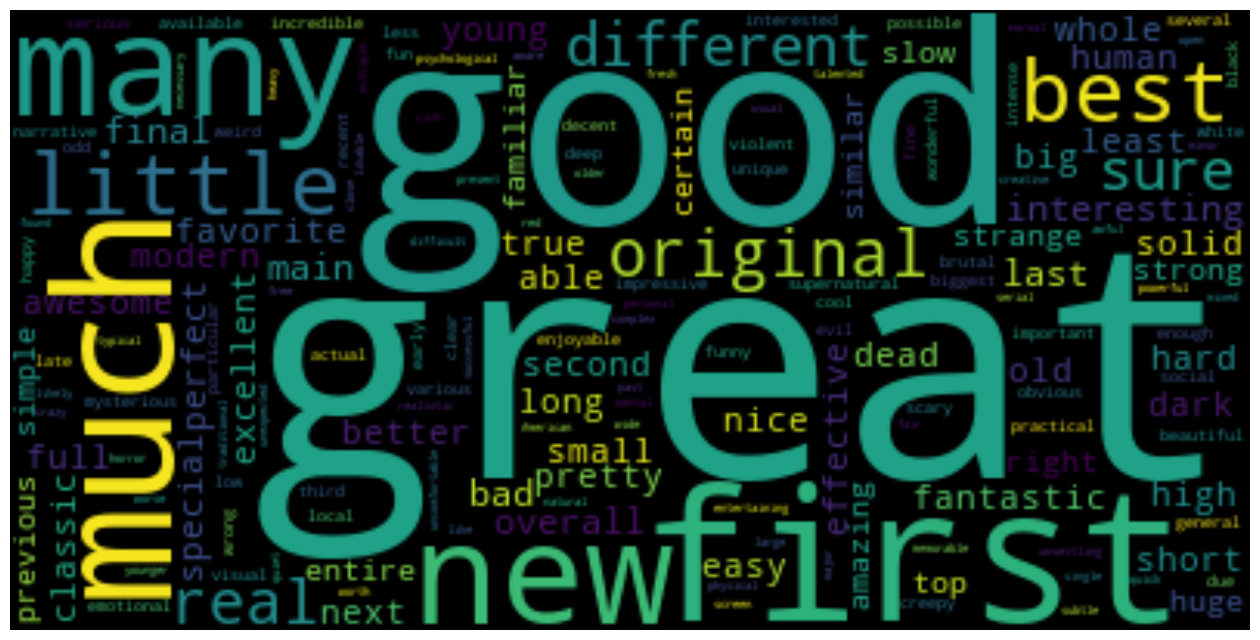

In [61]:
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = posData['selftext'].values

# Tokenize the text
tokens = [word_tokenize(sentence) for sentence in text]

# Perform part-of-speech tagging
pos_tags = [pos_tag(sentence) for sentence in tokens]

# Filter out adjectives
adjectives = [word for sentence in pos_tags for (word, tag) in sentence if tag.startswith('JJ')]

# Generate the word cloud
wc = WordCloud(max_words=200, stopwords=stopwords)
wc.generate(' '.join(adjectives))

plt.figure(figsize=(16, 9))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

These are the adjectives used for positive reviews in Reddit and it is possible to see that they are similar to those used in the training dataset.

## Future work

The movie titles and the creation of a scoring system could be added as part of an expansion of the aforementioned analysis. We can develop a  grading system by taking into account the title together with other review elements and the sentiment. This scoring system can then be used to predict the movie's rating and then compare it to the actual IMDb rating, considered as groundtruth.